In [0]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50 as resnet

In [0]:
import cv2
import os
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout,Flatten,Conv2D,MaxPool2D,Dense, BatchNormalization, Input, AveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline

In [3]:
! git clone https://github.com/AnnaFilipov93/flowers-analyzer

Cloning into 'flowers-analyzer'...
remote: Enumerating objects: 1420, done.
remote: Counting objects: 100% (1420/1420), done.
remote: Compressing objects: 100% (1417/1417), done.
remote: Total 5838 (delta 3), reused 1412 (delta 3), pack-reused 4418
Receiving objects: 100% (5838/5838), 474.93 MiB | 33.33 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Checking out files: 100% (5216/5216), done.


In [0]:
BATCH_SIZE=32
STEP=4154 // BATCH_SIZE
VALID_STEPS=1050  // BATCH_SIZE
SHAPE = (224,224)
INIT_LR = 1e-4

In [0]:
#prepering the data
train_image_gen=ImageDataGenerator(rotation_range=25,
	zoom_range=0.1,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.2,
	horizontal_flip=True,
	fill_mode="nearest")

val_image_gen=ImageDataGenerator(rescale=1./255)


In [6]:
##~~reading the data ~~##
train_dir=os.path.join(os.getcwd(), 'flowers-analyzer/flowers/train')
test_dir=os.path.join(os.getcwd(), 'flowers-analyzer/flowers/test')

train_img=train_image_gen.flow_from_directory(train_dir,
                                         target_size=SHAPE, batch_size=BATCH_SIZE,
                                       class_mode='categorical')


test_img=train_image_gen.flow_from_directory(test_dir,
                                       target_size=SHAPE, batch_size=BATCH_SIZE, 
                                        class_mode='categorical')


Found 4154 images belonging to 6 classes.
Found 1050 images belonging to 6 classes.


In [7]:
baseModel = resnet(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

94773248/94765736 [==============================] - 1s 0us/step


In [0]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(6, activation="softmax")(headModel)


In [0]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [0]:
for layer in baseModel.layers:
	layer.trainable = False

In [13]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / 10)
#before manual opt - acc - 95% | val acc - 85% | 20 epochs
#after acc - 88% | val acc - 85% | 10 epochs
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_img,epochs=10, steps_per_epoch=STEP,
    validation_data=test_img, validation_steps=VALID_STEPS)

Epoch 1/10
129/129 [==============================] - 88s 684ms/step - loss: 0.5985 - accuracy: 0.7831 - val_loss: 0.3511 - val_accuracy: 0.8711
Epoch 2/10
129/129 [==============================] - 85s 657ms/step - loss: 0.4693 - accuracy: 0.8304 - val_loss: 0.3014 - val_accuracy: 0.9014
Epoch 3/10
129/129 [==============================] - 86s 668ms/step - loss: 0.4165 - accuracy: 0.8493 - val_loss: 0.2926 - val_accuracy: 0.9023
Epoch 4/10
129/129 [==============================] - 88s 684ms/step - loss: 0.3752 - accuracy: 0.8680 - val_loss: 0.2670 - val_accuracy: 0.9150
Epoch 5/10
129/129 [==============================] - 86s 664ms/step - loss: 0.3324 - accuracy: 0.8787 - val_loss: 0.2551 - val_accuracy: 0.9072
Epoch 6/10
129/129 [==============================] - 86s 664ms/step - loss: 0.3133 - accuracy: 0.8862 - val_loss: 0.2751 - val_accuracy: 0.9043
Epoch 7/10
129/129 [==============================] - 88s 678ms/step - loss: 0.3026 - accuracy: 0.8962 - val_loss: 0.2740 - val_ac

In [0]:
model.save('fine_tuned_resnet50_classifier.h5')

In [15]:
labels = train_img.class_indices
Y_pred = model.predict_generator(test_img,STEP)
y_pred = np.argmax(Y_pred, axis=1)
print(labels)
print(confusion_matrix(test_img.classes,y_pred))


Instructions for updating:
Please use Model.predict, which supports generators.
{'daisy': 0, 'dandelion': 1, 'iris': 2, 'rose': 3, 'sunflower': 4, 'tulip': 5}
[[24 48 27 31 19 26]
 [27 21 42 30 30 25]
 [27 28 38 24 28 30]
 [44 18 30 33 19 31]
 [31 24 32 22 38 28]
 [31 27 29 25 31 32]]


(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae87185c18>)

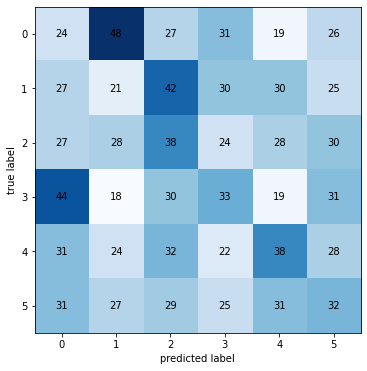

In [17]:

mat=confusion_matrix(test_img.classes,y_pred)
plot_confusion_matrix(conf_mat=mat,figsize=(6,6))

In [0]:
# In case the model pre-trained
model=load_model('five_flowers_model.h5')

----------------------------------------------------------- NOT FINE TUNED RESNET BELOW ------------------------------------------------------------------------

In [0]:
def resnet50_train():
    model = Sequential()

    model.add(resnet(include_top=False, pooling='avg', weights='imagenet'))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))

    model.layers[0].trainable = False
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit_generator(
        train_img,epochs=20, steps_per_epoch=STEP,
        validation_data=test_img, validation_steps=VALID_STEPS)

    return model


In [0]:
model = resnet50_train()

----- WITH BIAS : loss: 0.3830 - accuracy: 0.8700 - val_loss: 0.6431 - val_accuracy: 0.8012
----- WITHOUT BIAS : loss: 0.4067 - accuracy: 0.8603 - val_loss: 0.6585 - val_accuracy: 0.8000

In [0]:
from IPython.display import Image, display

import os, random
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
img_locations = []
for d in os.listdir("flowers-analyzer/flowers/FLOWERS/test/"):
    directory = "flowers-analyzer/flowers/FLOWERS/test/" + d
    sample = [directory + '/' + s for s in random.sample(
        os.listdir(directory), int(random.random()*10))]
    img_locations += sample

In [0]:
def read_and_prep_images(img_paths, img_height=224, img_width=224):
    imgs = [load_img(img_path, target_size=(224, 224)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    return preprocess_input(img_array)

random.shuffle(img_locations)
imgs = read_and_prep_images(img_locations)
predictions = model.predict_classes(imgs)
classes = dict((v,k) for k,v in train_img.class_indices.items())

for img, prediction in zip(img_locations, predictions):
    display(Image(img))
    print(classes[prediction])

In [0]:
'''def train_model():
    ###~~~building the model~~~###

    model=Sequential()

    #conv layer I
    model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(240,240,3),
                    activation='relu'))
    #pooling layer I
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    #conv layer II
    model.add(Conv2D(filters=64, kernel_size=(3,3),
                    activation='relu'))
    #pooling layer II
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    #conv layer III
    model.add(Conv2D(filters=64, kernel_size=(3,3),
                    activation='relu'))
    #pooling layer III
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    #conv layer IV
    model.add(Conv2D(filters=64, kernel_size=(3,3),
                    activation='relu'))
    #pooling layer IV
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    #conv layer V
    #model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(240,240,3),
    #                 activation='relu'))
    #pooling layer V
    #model.add(MaxPool2D(pool_size=(2,2)))

    #conv layer VI
    #model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(240,240,3),
    #                 activation='relu'))
    #pooling layer VI
    #model.add(MaxPool2D(pool_size=(2,2)))

    #flatten
    model.add(Flatten())

    #Dense layer
    model.add(Dense(512,activation='relu'))

    #dropout layer
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    #output layer
    model.add(Dense(5,activation='softmax'))

    model.summary()

    #compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    ###~~~training the model~~~###

    results=model.fit_generator(train_img,epochs=1, steps_per_epoch=1,
                                validation_data=test_img, validation_steps=27)

    return model'''

---------- manual checking of the model performence ---------------

In [0]:
###~~~testing on the tests images~~~###

examples = ['FLOWERS//test//daisy/144076848_57e1d662e3_m.jpg',
            'FLOWERS//test//dandelion/14740350060_a489d9fa06.jpg',
            'FLOWERS//test/tulip/5633266048_4f4bfb2cf1_n.jpg',
            'FLOWERS//test/sunflower/21728822928_9f6817325a_n.jpg',
            'flowers//FLOWERS//test//rose/random_flower.jpg']


In [0]:
def pred (p, pred_acc):
    if pred_acc[0,p]<0.7:
        print("the model couldn't recognize it")
    elif p==0:
        print("the model recognized it as a daisy")
    elif p==1:
         print("the model recognized it as a dandelion")
    elif p==2:
          print("the model recognized it as a rose")
    elif p==3:
          print("the model recognized it as a sunflower")       
    elif p==4:
          print("the model recognized it as a tulip")     
            

In [0]:
def predict_flower(path):
  flower=cv2.imread(path)
  flower=cv2.cvtColor(flower,cv2.COLOR_BGR2RGB)
  plt.imshow(flower)

  flower_file=path
  flower_img=image.load_img(flower_file, target_size=(240,240))
  flower_img=image.img_to_array(flower_img)
  flower_img=np.expand_dims(flower_img,axis=0)
  flower_img=flower_img/255

  p=model.predict_classes(flower_img)
  pred(p)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()